In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
df = pd.read_csv("100000 Sales Records.csv")


In [5]:
df.shape, df.columns, df.head()


((100000, 14),
 Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
        'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
        'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
       dtype='object'),
                               Region                Country      Item Type  \
 0       Middle East and North Africa             Azerbaijan         Snacks   
 1  Central America and the Caribbean                 Panama      Cosmetics   
 2                 Sub-Saharan Africa  Sao Tome and Principe         Fruits   
 3                 Sub-Saharan Africa  Sao Tome and Principe  Personal Care   
 4  Central America and the Caribbean                 Belize      Household   
 
   Sales Channel Order Priority Order Date   Order ID   Ship Date  Units Sold  \
 0        Online              C  10/8/2014  535113847  10/23/2014         934   
 1       Offline              L  2/22/2015  874708545   2/27/2015        4551   
 2       Offline     

In [6]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          100000 non-null  object 
 1   Country         100000 non-null  object 
 2   Item Type       100000 non-null  object 
 3   Sales Channel   100000 non-null  object 
 4   Order Priority  100000 non-null  object 
 5   Order Date      100000 non-null  object 
 6   Order ID        100000 non-null  int64  
 7   Ship Date       100000 non-null  object 
 8   Units Sold      100000 non-null  int64  
 9   Unit Price      100000 non-null  float64
 10  Unit Cost       100000 non-null  float64
 11  Total Revenue   100000 non-null  float64
 12  Total Cost      100000 non-null  float64
 13  Total Profit    100000 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 10.7+ MB


Region            0
Country           0
Item Type         0
Sales Channel     0
Order Priority    0
Order Date        0
Order ID          0
Ship Date         0
Units Sold        0
Unit Price        0
Unit Cost         0
Total Revenue     0
Total Cost        0
Total Profit      0
dtype: int64

In [7]:
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%m/%d/%Y")
df["Order Month"] = df["Order Date"].dt.to_period("M").astype(str)


In [8]:
agg = df.groupby(
    ["Country", "Item Type", "Sales Channel", "Order Month"]
).size().reset_index(name="Number of Orders")
agg.shape, agg.head()


((87928, 5),
        Country  Item Type Sales Channel Order Month  Number of Orders
 0  Afghanistan  Baby Food       Offline     2010-01                 1
 1  Afghanistan  Baby Food       Offline     2010-07                 1
 2  Afghanistan  Baby Food       Offline     2010-09                 1
 3  Afghanistan  Baby Food       Offline     2010-12                 1
 4  Afghanistan  Baby Food       Offline     2011-02                 1)

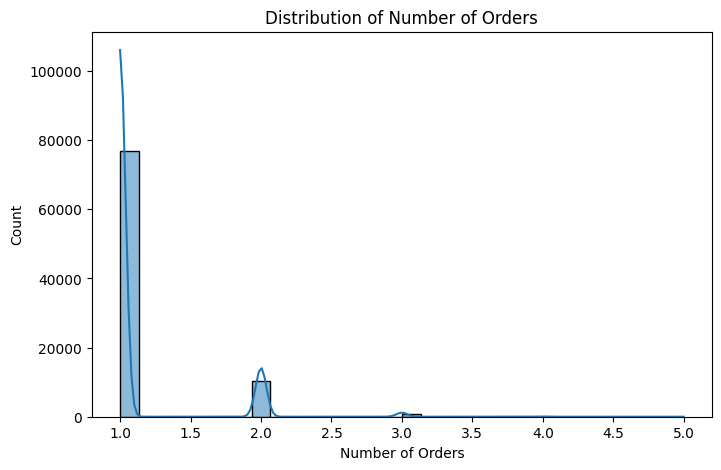

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(agg["Number of Orders"], bins=30, kde=True)
plt.title("Distribution of Number of Orders")
plt.show()


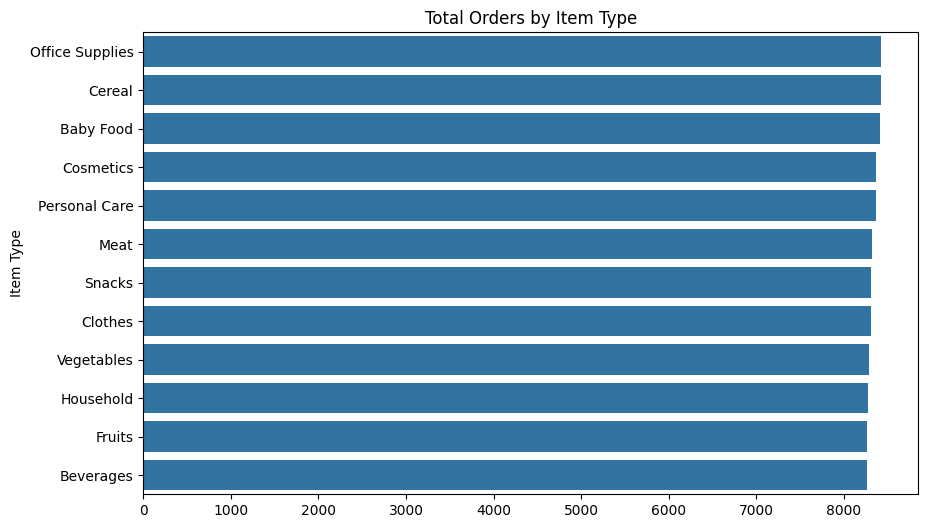

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(
    x=agg.groupby("Item Type")["Number of Orders"].sum().sort_values(ascending=False).values,
    y=agg.groupby("Item Type")["Number of Orders"].sum().sort_values(ascending=False).index
)
plt.title("Total Orders by Item Type")
plt.show()


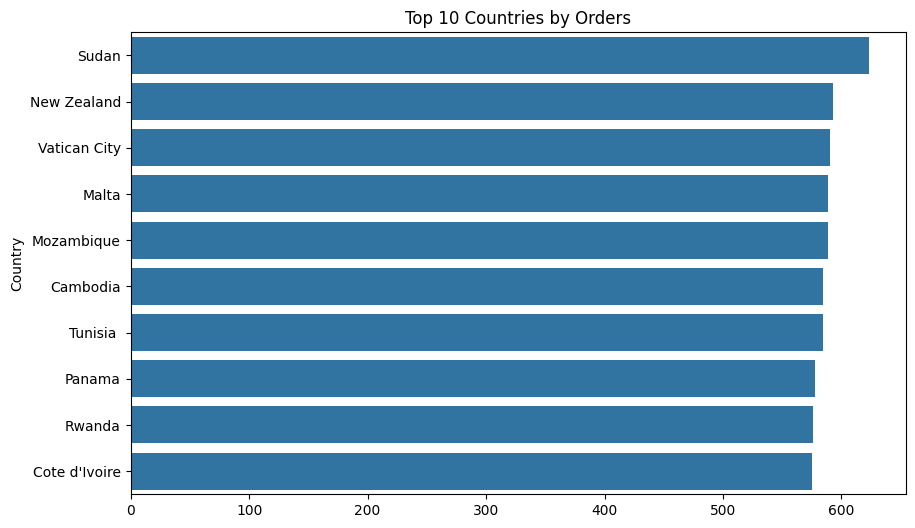

In [11]:
top_countries = agg.groupby("Country")["Number of Orders"].sum().nlargest(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 Countries by Orders")
plt.show()


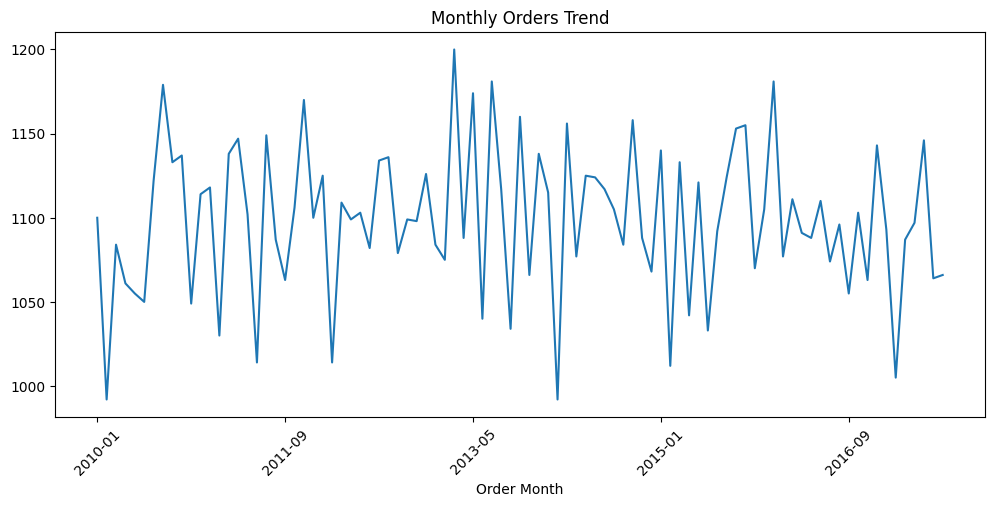

In [12]:
monthly = agg.groupby("Order Month")["Number of Orders"].sum()
plt.figure(figsize=(12,5))
monthly.plot()
plt.title("Monthly Orders Trend")
plt.xticks(rotation=45)
plt.show()


In [13]:
enc = pd.get_dummies(
    agg,
    columns=["Country", "Item Type", "Sales Channel", "Order Month"],
    drop_first=True
)
enc.shape


(87928, 287)

In [14]:
X = enc.drop("Number of Orders", axis=1)
y = enc["Number of Orders"]



In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
print("LR MSE:", round(mean_squared_error(y_test, y_lr),4))
print("LR R² :", round(r2_score(y_test, y_lr),4))


LR MSE: 0.1438
LR R² : -0.0022


In [ ]:
rf = RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
print("RF MSE:", round(mean_squared_error(y_test, y_rf),4))
print("RF R² :", round(r2_score(y_test, y_rf),4))



In [19]:
hgb = HistGradientBoostingRegressor(max_iter=100, random_state=42)
hgb.fit(X_train, y_train)
y_hgb = hgb.predict(X_test)
print("HGB MSE:", round(mean_squared_error(y_test, y_hgb),4))
print("HGB R²:", round(r2_score(y_test, y_hgb),4))


HGB MSE: 0.1436
HGB R²: -0.0006


In [20]:
results = pd.DataFrame({
    "Model": ["LinearRegression", "RandomForest", "HistGB"],
    "MSE": [
        mean_squared_error(y_test, y_lr),
        mean_squared_error(y_test, y_rf),
        mean_squared_error(y_test, y_hgb)
    ],
    "R2": [
        r2_score(y_test, y_lr),
        r2_score(y_test, y_rf),
        r2_score(y_test, y_hgb)
    ]
})
results.round(4)


,Model,MSE,R2
0,LinearRegression,0.1438,-0.0022
1,RandomForest,0.1729,-0.2050
2,HistGB,0.1436,-0.0006


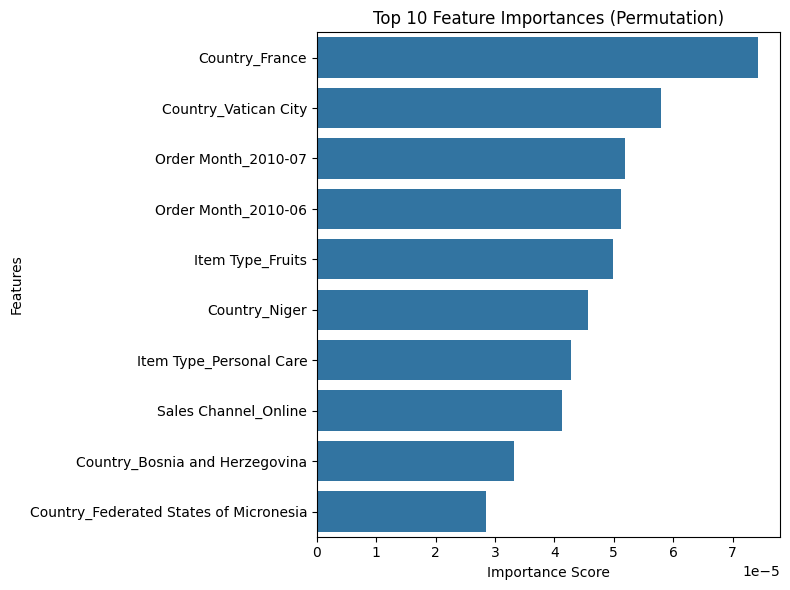

In [23]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result = permutation_importance(hgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

importances = pd.Series(result.importances_mean, index=enc.drop("Number of Orders", axis=1).columns).nlargest(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 10 Feature Importances (Permutation)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import randint, uniform

param_dist = {
    "learning_rate": uniform(0.01, 0.3),
    "max_iter": randint(100, 500),
    "max_depth": randint(3, 15),
    "min_samples_leaf": randint(20, 100),
    "l2_regularization": uniform(0.0, 1.0),
}

search = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000259F1DA8D10>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000259F15B6D50>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000259F14A6C90>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000259F1CA8290>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000259F13A1C10>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [25]:
best_hgb = HistGradientBoostingRegressor(
    learning_rate=0.0295,
    max_iter=188,
    max_depth=6,
    min_samples_leaf=79,
    l2_regularization=0.1705,
    random_state=42
)

best_hgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_hgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Tuned HistGB Model Performance:")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


Tuned HistGB Model Performance:
MSE: 0.1435
R²: -0.0000


In [26]:
# Model Results DataFrame
model_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'HistGradientBoosting', 'Tuned HistGradientBoosting'],
    'MSE': [0.1438, 0.1729, 0.1436, 0.1435],
    'R2': [-0.0022, -0.2050, -0.0006, -0.0000]
})

# Display Results
model_results


,Model,MSE,R2
0,Linear Regression,0.1438,-0.0022
1,Random Forest,0.1729,-0.2050
2,HistGradientBoosting,0.1436,-0.0006
3,Tuned HistGradientBoosting,0.1435,-0.0000


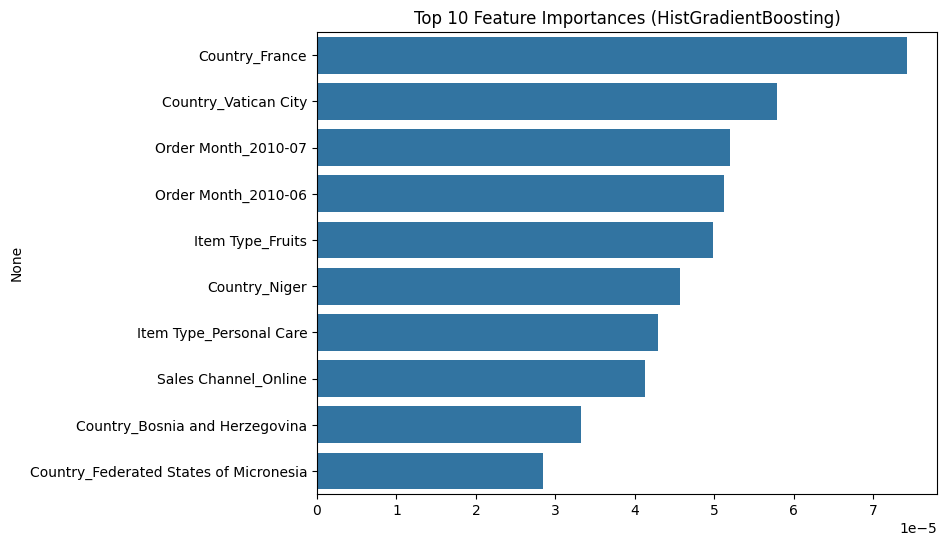

In [28]:
# Convert X_test to DataFrame with original column names
X_test_df = pd.DataFrame(X_test, columns=enc.drop("Number of Orders", axis=1).columns)

# Now calculate feature importance
importances = pd.Series(result.importances_mean, index=X_test_df.columns).nlargest(10)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 10 Feature Importances (HistGradientBoosting)")
plt.show()


### Conclusion:

In this project, we aimed to predict the **Number of Orders** based on various features from a sales dataset. The models tested include **Linear Regression**, **Random Forest**, and **HistGradientBoosting**.

- **Linear Regression** performed decently with an **MSE of 0.1438** and **R² of -0.0022**.
- **Random Forest** was the least effective, with a **MSE of 0.1729** and **R² of -0.2050**, indicating overfitting and worse performance.
- **HistGradientBoosting** without tuning had an **MSE of 0.1436** and **R² of -0.0006**, which was slightly better than Linear Regression.
- After **hyperparameter tuning** using **RandomizedSearchCV**, the **HistGradientBoosting** model achieved an **MSE of 0.1435** and an **R² of -0.0000**, showing marginal improvement.

While **HistGradientBoosting** with tuning offered slight improvement, the model still doesn't explain much of the variance in the data, which suggests that other factors or additional features may need to be considered for better performance.
